In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import trimesh
from skimage import measure
from torch import nn, optim
from torch.autograd import grad

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


# Data generation

In [ ]:
# Ground-truth SDF for a sphere
def sdf_sphere(x, R=1.0):
    # x: [N, 3] torch tensor
    return x.norm(dim=-1, keepdim=True) - R


def sample_sphere_surface(num_points=5000, R=1.0, noise_std=0.02, occlude=True):
    # Sample points uniformly on sphere surface using normal distribution
    # then normalization to radius R
    xyz = torch.randn(num_points, 3)
    xyz = R * xyz / xyz.norm(dim=-1, keepdim=True)

    # Optional: occlude one region (e.g. z > 0.5)
    if occlude:
        mask = xyz[:, 2] < 0.5
        xyz = xyz[mask]

    # Add Gaussian noise
    xyz_noisy = xyz + noise_std * torch.randn_like(xyz)
    return xyz_noisy


def sample_volume_points(num_points=10000, bounds=(-1.5, 1.5)):
    low, high = bounds
    xyz = torch.empty(num_points, 3).uniform_(low, high)
    return xyz


# Generate data
num_pc_points = 4000
num_vol_points = 8000

X_pc = sample_sphere_surface(
    num_points=num_pc_points,
    R=1.0,
    noise_std=0.03,
    occlude=True,
).to(device)
X_vol = sample_volume_points(num_points=num_vol_points, bounds=(-1.5, 1.5)).to(device)

print("Point cloud shape:", X_pc.shape)
print("Volume points shape:", X_vol.shape)

Point cloud shape: torch.Size([3007, 3])
Volume points shape: torch.Size([8000, 3])


# Baseline MLP implicit model

Simple fully-connected network: input 3D coords, output SDF value.

In [ ]:
class MLPImplicit(nn.Module):
    def __init__(self, in_dim=3, hidden_dim=128, out_dim=1, num_layers=4):
        super().__init__()
        layers = []
        dims = [in_dim] + [hidden_dim] * (num_layers - 1) + [out_dim]
        for i in range(len(dims) - 2):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.Softplus(beta=100))  # smooth non-linear (approx ReLU)
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Simple KAN implementation

Very simple Kolmogorov–Arnold-like structure:
 - First linear layer to latent dimension.
 - Sum of univariate nonlinear functions applied per coordinate (via small 1D MLPs).
 - Final linear layer back to scalar.

In [ ]:
class UnivariateMLP(nn.Module):
    """Small MLP implementing a univariate function phi: R -> R
    Used as 'basis' in the KAN construction.
    """

    def __init__(self, hidden_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x):
        # x: [N, 1]
        return self.net(x)


class KANImplicit(nn.Module):
    """Very simplified KAN-style network:
    f(x) = W2 * sum_i phi_i(W1 * x)_i + b2
    where each phi_i is a univariate MLP.
    """

    def __init__(self, in_dim=3, latent_dim=32, out_dim=1):
        super().__init__()
        self.in_dim = in_dim
        self.latent_dim = latent_dim
        self.out_dim = out_dim

        # First linear mapping: R^3 -> R^latent_dim
        self.lin1 = nn.Linear(in_dim, latent_dim)

        # Univariate functions on each latent dimension
        self.univar = nn.ModuleList(
            [UnivariateMLP(hidden_dim=16) for _ in range(latent_dim)],
        )

        # Final linear mapping: R^latent_dim -> R^1
        self.lin2 = nn.Linear(latent_dim, out_dim)

    def forward(self, x):
        # x: [N, 3]
        z = self.lin1(x)  # [N, latent_dim]

        # Apply univariate function to each latent dimension
        # and collect
        phi_z = []
        for i in range(self.latent_dim):
            zi = z[:, i : i + 1]  # [N, 1]
            phi_zi = self.univar[i](zi)  # [N, 1]
            phi_z.append(phi_zi)

        phi_z = torch.cat(phi_z, dim=-1)  # [N, latent_dim]

        out = self.lin2(phi_z)  # [N, 1]
        return out

# Physics-informed loss

In [ ]:
def gradient(outputs, inputs):
    """Compute gradient of outputs w.r.t. inputs.
    outputs: [N, 1]
    inputs: [N, D]
    returns: [N, D]
    """
    return grad(
        outputs=outputs,
        inputs=inputs,
        grad_outputs=torch.ones_like(outputs),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]


def laplacian(outputs, inputs):
    """Compute Laplacian of outputs w.r.t. inputs using second derivatives.
    outputs: [N, 1]
    inputs: [N, D]
    returns: [N, 1]
    """
    # First gradient: [N, D]
    grads = gradient(outputs, inputs)

    lap = 0.0
    # For each dimension, second derivative
    for d in range(inputs.shape[-1]):
        grad_d = grads[:, d : d + 1]  # [N, 1]
        grad2_d = grad(
            outputs=grad_d,
            inputs=inputs,
            grad_outputs=torch.ones_like(grad_d),
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0][:, d : d + 1]  # [N, 1]
        lap = lap + grad2_d
    return lap


def pinn_losses(
    model,
    X_pc,
    X_vol,
    lambda_data=1.0,
    lambda_eik=0.1,
    lambda_lap=0.01,
    use_true_sdf_for_data=False,
):
    """Compute total loss + breakdown for the implicit surface model.
    - model: implicit network
    - X_pc: noisy point cloud [N_pc, 3]
    - X_vol: volume sample points [N_vol, 3]
    """
    X_pc = X_pc.requires_grad_(True)
    X_vol = X_vol.requires_grad_(True)

    # 1) Data term
    f_pc = model(X_pc)  # [N_pc, 1]

    if use_true_sdf_for_data:
        # For PoC, optionally use ground truth SDF
        sdf_true_pc = sdf_sphere(X_pc)
        L_data = (f_pc - sdf_true_pc).pow(2).mean()
    else:
        # Unlabeled PC: enforce |f| ~ 0 on observed points
        L_data = f_pc.abs().mean()

    # 2) Eikonal term
    f_vol = model(X_vol)  # [N_vol, 1]
    grads_vol = gradient(f_vol, X_vol)  # [N_vol, 3]
    grad_norm = grads_vol.norm(dim=-1, keepdim=True)
    L_eik = (grad_norm - 1.0).pow(2).mean()

    # 3) Laplacian term
    lap_vol = laplacian(f_vol, X_vol)  # [N_vol, 1]
    L_lap = (lap_vol**2).mean()

    L_total = lambda_data * L_data + lambda_eik * L_eik + lambda_lap * L_lap

    losses = {
        "L_total": L_total,
        "L_data": L_data,
        "L_eik": L_eik,
        "L_lap": L_lap,
    }
    return losses

# Training

In [ ]:
def train_model(
    model,
    X_pc,
    X_vol,
    n_iters=3000,
    lr=1e-3,
    lambda_data=1.0,
    lambda_eik=0.1,
    lambda_lap=0.01,
    use_true_sdf_for_data=False,
    verbose_every=200,
):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {"L_total": [], "L_data": [], "L_eik": [], "L_lap": []}

    for it in range(1, n_iters + 1):
        optimizer.zero_grad()
        losses = pinn_losses(
            model,
            X_pc,
            X_vol,
            lambda_data=lambda_data,
            lambda_eik=lambda_eik,
            lambda_lap=lambda_lap,
            use_true_sdf_for_data=use_true_sdf_for_data,
        )

        losses["L_total"].backward()
        optimizer.step()

        for k in history:
            history[k].append(losses[k].item())

        if it % verbose_every == 0:
            print(
                f"[Iter {it}/{n_iters}] "
                f"L_total={losses['L_total'].item():.4e}, "
                f"L_data={losses['L_data'].item():.4e}, "
                f"L_eik={losses['L_eik'].item():.4e}, "
                f"L_lap={losses['L_lap'].item():.4e}",
            )
    return model, history

In [10]:
# Hyperparameters
n_iters = 2500
lambda_data = 1.0
lambda_eik = 0.1
lambda_lap = 0.01
lr = 1e-3
use_true_sdf_for_data = True  # for stable demo; set False for 'realistic' scan scenario

# Baseline MLP
mlp_model = MLPImplicit(in_dim=3, hidden_dim=128, out_dim=1, num_layers=4)
print("Training MLP model...")
mlp_model, mlp_history = train_model(
    mlp_model,
    X_pc,
    X_vol,
    n_iters=n_iters,
    lr=lr,
    lambda_data=lambda_data,
    lambda_eik=lambda_eik,
    lambda_lap=lambda_lap,
    use_true_sdf_for_data=use_true_sdf_for_data,
    verbose_every=250,
)

# KAN model
kan_model = KANImplicit(in_dim=3, latent_dim=32, out_dim=1)
print("\nTraining KAN model...")
kan_model, kan_history = train_model(
    kan_model,
    X_pc,
    X_vol,
    n_iters=n_iters,
    lr=lr,
    lambda_data=lambda_data,
    lambda_eik=lambda_eik,
    lambda_lap=lambda_lap,
    use_true_sdf_for_data=use_true_sdf_for_data,
    verbose_every=250,
)


Training KAN model...
[Iter 250/2500] L_total=2.5689e-02, L_data=5.2805e-03, L_eik=1.3331e-01, L_lap=7.0775e-01
[Iter 500/2500] L_total=1.6537e-02, L_data=1.8937e-03, L_eik=5.8284e-02, L_lap=8.8151e-01
[Iter 750/2500] L_total=1.6181e-02, L_data=1.9197e-03, L_eik=5.6388e-02, L_lap=8.6222e-01
[Iter 1000/2500] L_total=1.5925e-02, L_data=2.0205e-03, L_eik=5.6180e-02, L_lap=8.2863e-01
[Iter 1250/2500] L_total=1.5793e-02, L_data=2.1495e-03, L_eik=5.6652e-02, L_lap=7.9778e-01
[Iter 1500/2500] L_total=1.5131e-02, L_data=2.8764e-03, L_eik=5.9133e-02, L_lap=6.3418e-01
[Iter 1750/2500] L_total=1.4623e-02, L_data=2.8541e-03, L_eik=5.7469e-02, L_lap=6.0221e-01
[Iter 2000/2500] L_total=1.4472e-02, L_data=2.8806e-03, L_eik=5.6603e-02, L_lap=5.9306e-01
[Iter 2250/2500] L_total=1.4379e-02, L_data=2.8656e-03, L_eik=5.6400e-02, L_lap=5.8730e-01
[Iter 2500/2500] L_total=1.4240e-02, L_data=2.8091e-03, L_eik=5.5972e-02, L_lap=5.8339e-01


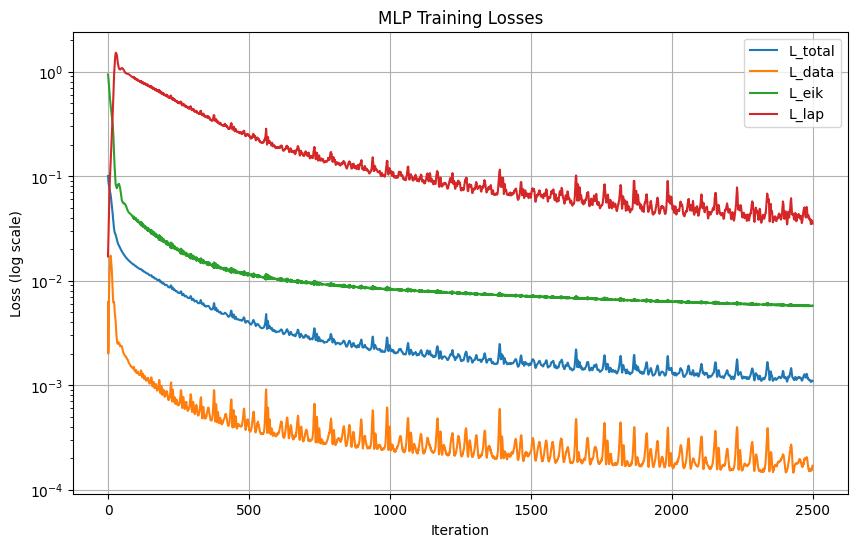

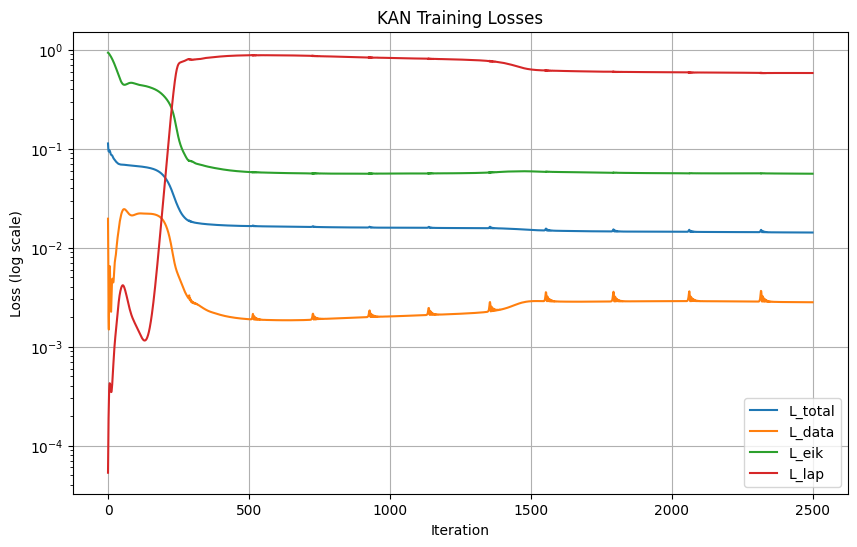

In [11]:
def plot_history(history, title="Training Loss Curves"):
    plt.figure(figsize=(10, 6))
    for k in ["L_total", "L_data", "L_eik", "L_lap"]:
        plt.plot(history[k], label=k)
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("Loss (log scale)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


plot_history(mlp_history, title="MLP Training Losses")
plot_history(kan_history, title="KAN Training Losses")

# Surface extraction via marching cubes 

- Evaluate f(x) on a 3D grid.
- Run marching cubes.
- Visualize reconstructions for both MLP and KAN.
     

In [14]:
def extract_mesh(model, bounds=(-1.5, 1.5), resolution=64, level=0.0):
    model.eval()
    with torch.no_grad():
        low, high = bounds
        xs = np.linspace(low, high, resolution)
        ys = np.linspace(low, high, resolution)
        zs = np.linspace(low, high, resolution)

        grid_x, grid_y, grid_z = np.meshgrid(xs, ys, zs, indexing="ij")
        coords = np.stack([grid_x, grid_y, grid_z], axis=-1)  # [res, res, res, 3]
        coords_flat = torch.from_numpy(coords.reshape(-1, 3)).float().to(device)

        # Evaluate model
        f_vals = []
        batch_size = 4096
        for i in range(0, coords_flat.shape[0], batch_size):
            batch = coords_flat[i : i + batch_size]
            f_batch = model(batch)
            f_vals.append(f_batch.cpu().numpy())
        f_vals = np.concatenate(f_vals, axis=0)
        f_grid = f_vals.reshape(resolution, resolution, resolution)

        # Marching cubes: note that skimage expects (z, y, x) order
        verts, faces, normals, values = measure.marching_cubes(
            volume=f_grid.transpose(2, 1, 0),  # reorder axes
            level=level,
            spacing=((high - low) / (resolution - 1),) * 3,
        )

        # Shift vertices back to correct coordinates
        # marching_cubes returns coordinates in physical units given spacing starting at 0
        # We need to offset by low
        verts += low

        mesh = trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals)
        return mesh


# Extract meshes
mlp_mesh = extract_mesh(mlp_model, bounds=(-1.5, 1.5), resolution=64, level=0.0)
kan_mesh = extract_mesh(kan_model, bounds=(-1.5, 1.5), resolution=64, level=0.0)

print("MLP mesh:", mlp_mesh)
print("KAN mesh:", kan_mesh)

MLP mesh: <trimesh.Trimesh(vertices.shape=(11952, 3), faces.shape=(23642, 3))>
KAN mesh: <trimesh.Trimesh(vertices.shape=(13236, 3), faces.shape=(25974, 3))>


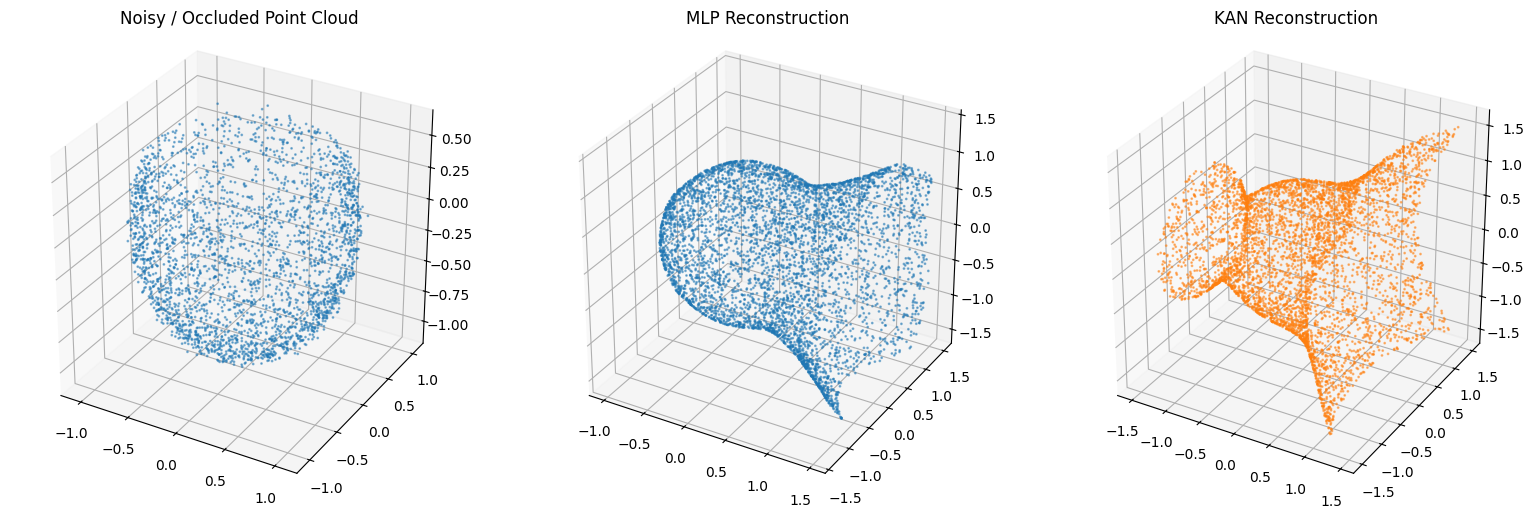

In [16]:
# Sample points from meshes for visualization
mlp_points = torch.tensor(mlp_mesh.sample(5000), dtype=torch.float32)
kan_points = torch.tensor(kan_mesh.sample(5000), dtype=torch.float32)

# Move to numpy
mlp_pts_np = mlp_points.numpy()
kan_pts_np = kan_points.numpy()
pc_np = X_pc.detach().numpy()

# Plot
fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(131, projection="3d")
ax1.scatter(pc_np[:, 0], pc_np[:, 1], pc_np[:, 2], s=1, alpha=0.5)
ax1.set_title("Noisy / Occluded Point Cloud")
ax1.set_box_aspect([1, 1, 1])

ax2 = fig.add_subplot(132, projection="3d")
ax2.scatter(
    mlp_pts_np[:, 0],
    mlp_pts_np[:, 1],
    mlp_pts_np[:, 2],
    s=1,
    alpha=0.5,
    c="tab:blue",
)
ax2.set_title("MLP Reconstruction")
ax2.set_box_aspect([1, 1, 1])

ax3 = fig.add_subplot(133, projection="3d")
ax3.scatter(
    kan_pts_np[:, 0],
    kan_pts_np[:, 1],
    kan_pts_np[:, 2],
    s=1,
    alpha=0.5,
    c="tab:orange",
)
ax3.set_title("KAN Reconstruction")
ax3.set_box_aspect([1, 1, 1])

plt.tight_layout()
plt.show()

# Chamfer distance for quantitative comparison

In [17]:
def sample_gt_sphere(num_points=10000, R=1.0):
    xyz = torch.randn(num_points, 3)
    xyz = R * xyz / xyz.norm(dim=-1, keepdim=True)
    return xyz


def chamfer_distance(A, B):
    """A: [Na, 3], B: [Nb, 3]
    Very simple (O(N^2)) Chamfer for demo. For higher resolution, use a library.
    """
    A = torch.tensor(A, dtype=torch.float32)
    B = torch.tensor(B, dtype=torch.float32)

    # [Na, Nb, 3]
    diff = A[:, None, :] - B[None, :, :]
    dist2 = (diff**2).sum(dim=-1)  # [Na, Nb]
    # For each point in A, min distance to B
    minA = dist2.min(dim=1)[0]
    # For each point in B, min distance to A
    minB = dist2.min(dim=0)[0]
    cd = minA.mean() + minB.mean()
    return cd.item()


gt_pts = sample_gt_sphere(num_points=5000, R=1.0).numpy()
mlp_cd = chamfer_distance(mlp_pts_np, gt_pts)
kan_cd = chamfer_distance(kan_pts_np, gt_pts)

print(f"Chamfer distance (MLP vs GT): {mlp_cd:.4e}")
print(f"Chamfer distance (KAN vs GT): {kan_cd:.4e}")

Chamfer distance (MLP vs GT): 2.5534e-01
Chamfer distance (KAN vs GT): 3.4450e-01
